In [1]:
import os, math, numpy as np, pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from pandas import read_csv
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import MessagePassing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import networkx as nx

In [2]:

EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
ID_COLS = ['Src IP','Dst IP','Timestamp']
LABEL_COL = 'target'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32377064 entries, 0 to 32377063
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Timestamp                object 
 1   Src IP                   object 
 2   Dst IP                   object 
 3   Bwd Packet Length Min    int64  
 4   Protocol_6               bool   
 5   Bwd Packets/s            float64
 6   FWD Init Win Bytes       int64  
 7   Packet Length Std        float64
 8   FIN Flag Count           int64  
 9   SrcPortRange_registered  bool   
 10  Packet Length Min        int64  
 11  Fwd Seg Size Min         int64  
 12  DstPortRange_well_known  bool   
 13  Bwd IAT Total            int64  
 14  SYN Flag Count           int64  
 15  Bwd Packet Length Std    float64
 16  target                   int64  
dtypes: bool(3), float64(3), int64(8), object(3)
memory usage: 3.5+ GB


In [17]:
# def time_posenc(t, periods=(60, 300, 3600)):
#     # t: numpy array of epoch seconds
#     feats = []
#     for P in periods:
#         w = 2*math.pi/P
#         feats.append(np.sin(w*t))
#         feats.append(np.cos(w*t))
#     return np.stack(feats, axis=1)  # [N, 2*len(periods)]

def bin_time(df, bin_seconds=300):
    # Expect df['Timestamp'] as datetime or string; convert to seconds
    ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True).astype('int64') // 10**9
    df = df.copy()
    df['_epoch'] = ts
    df['_bin'] = (ts // bin_seconds).astype(int)
    return df

In [3]:
import numpy as np
import pandas as pd
from scipy import sparse

def compute_node_centralities_fast2(
    df: pd.DataFrame,
    ip2idx: dict,
    src_col: str = "Src IP",
    dst_col: str = "Dst IP",
    use_betweenness: bool = False,     # set True if you have NetworKit
    betw_samples: int = 32,            # NetworKit ApproxBetweenness samples
    pagerank_alpha: float = 0.85,
    pagerank_iters: int = 40,
    pagerank_tol: float = 1e-6,
    closeness_if_small: int = 20_000,  # only compute closeness if N <= this
    ktruss_if_small: int = 10_000      # only compute k-truss if N <= this
) -> np.ndarray:
    """
    Returns C: [N_nodes, 5] -> [degree, betweenness, closeness, pagerank, ktruss_level], z-scored per column.
    Fast path fills unavailable metrics with 0 (safe after z-scoring).
    """
    N = len(ip2idx)
    if N == 0:
        return np.zeros((0,5), dtype=float)

    # ------- Build sparse adjacency (directed) fast -------
    # Map to indices without Python loops
    src_idx = df[src_col].astype(str).map(ip2idx).to_numpy()
    dst_idx = df[dst_col].astype(str).map(ip2idx).to_numpy()
    mask = np.isfinite(src_idx) & np.isfinite(dst_idx)
    src_idx = src_idx[mask].astype(np.int64, copy=False)
    dst_idx = dst_idx[mask].astype(np.int64, copy=False)

    # Remove self-loops once (optional)
    non_self = src_idx != dst_idx
    src_idx, dst_idx = src_idx[non_self], dst_idx[non_self]

    data = np.ones_like(src_idx, dtype=np.float64)
    A = sparse.coo_matrix((data, (src_idx, dst_idx)), shape=(N, N)).tocsr()

    # ------- Degree (total degree for directed) -------
    outdeg = A.getnnz(axis=1)          # rows
    indeg  = A.getnnz(axis=0)          # cols
    degree = (outdeg + indeg).astype(np.float64)

    # ------- PageRank (power iteration on sparse) -------
    # Row-normalize A^T equivalent: P^T @ pr
    outdeg_safe = np.maximum(outdeg, 1)
    Dinv = sparse.diags(1.0 / outdeg_safe)
    P = Dinv @ A                       # row-stochastic (on rows)
    pr = np.full(N, 1.0 / N, dtype=np.float64)
    teleport = (1.0 - pagerank_alpha) / N
    for _ in range(pagerank_iters):
        pr_new = pagerank_alpha * (P.T @ pr) + teleport
        if np.linalg.norm(pr_new - pr, 1) < pagerank_tol:
            pr = pr_new
            break
        pr = pr_new

    # ------- Betweenness (optional, NetworKit) -------
    betw = np.zeros(N, dtype=np.float64)
    if use_betweenness:
        try:
            import networkit as nk
            # Build NetworKit graph
            Gnk = nk.Graph(n=N, weighted=False, directed=True)
            # Add edges (NetworKit expects int indices)
            # Faster add: iterate CSR rows
            rows, cols = A.nonzero()
            for u, v in zip(rows.tolist(), cols.tolist()):
                if u != v:
                    Gnk.addEdge(u, v)
            c = nk.centrality.ApproxBetweenness(Gnk, nSamples=int(betw_samples), normalized=True)
            c.run()
            betw = np.array(c.scores(), dtype=np.float64)
        except Exception:
            # If NetworKit not available, keep zeros (safe after z-score)
            pass

    # ------- Closeness (tiny graphs only, else zeros) -------
    clos = np.zeros(N, dtype=np.float64)
    if N <= closeness_if_small:
        try:
            import networkx as nx
            H = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph)
            # Use NX fast approximation? (still Python; okay for small N)
            clos_dict = nx.closeness_centrality(H)  # directed-version
            # Map dict to array by index order
            # NetworkX labels are 0..N-1 when built from scipy sparse
            clos = np.array([clos_dict.get(i, 0.0) for i in range(N)], dtype=np.float64)
        except Exception:
            pass

    # ------- k-truss (tiny graphs only, else zeros) -------
    ktr = np.zeros(N, dtype=np.float64)
    if N <= ktruss_if_small:
        try:
            import networkx as nx
            Hu = nx.from_scipy_sparse_array((A + A.T).sign(), create_using=nx.Graph)
            ktr_level = np.zeros(N, dtype=np.int32)
            for k in range(3, 7):  # modest bound; raise carefully
                try:
                    Tk = nx.k_truss(Hu, k)
                except nx.NetworkXError:
                    break
                nodes = list(Tk.nodes())
                if not nodes:
                    continue
                ktr_level[np.array(nodes, dtype=np.int64)] = np.maximum(ktr_level[np.array(nodes, dtype=np.int64)], k)
            ktr = ktr_level.astype(np.float64)
        except Exception:
            pass

    # ------- Pack in the right slot order: [degree, betweenness, closeness, pagerank, ktruss] -------
    C = np.column_stack([degree, betw, clos, pr, ktr])

    # ------- z-score per column (robust to zeros) -------
    mu = C.mean(axis=0, keepdims=True)
    sd = C.std(axis=0, keepdims=True) + 1e-8
    C = (C - mu) / sd
    return C


In [4]:
# Fast unique IP mapping (string-safe)
def make_ip_index(df, src_col='Src IP', dst_col='Dst IP'):
    # Combine columns as one numpy array without concat copies
    src = df[src_col].astype(str).to_numpy(copy=False)
    dst = df[dst_col].astype(str).to_numpy(copy=False)
    all_ips = np.concatenate((src, dst))

    # Use pandas categorical (internally fast hash-based unique)
    cat = pd.Categorical(all_ips)
    ip2idx = dict(zip(cat.categories, range(len(cat.categories))))
    n_nodes = len(ip2idx)
    return ip2idx, n_nodes

def build_snapshots(df, scaler_edge=None, fit_scaler=False, bin_seconds=300, device='cpu', include_per_bin_feats=True):
    """
    Returns:
      snapshots: list[Data] in time order
      ip2idx: dict mapping IP -> node index (per full dataset, stable across train/test)
      scaler_edge: fitted StandardScaler for edge features
      edge_cols_kept: list of columns used (existing + non-NA + time enc + centralities names)
    """
    # Keep only available columns
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols_needed = ID_COLS + edge_cols + [LABEL_COL]
    cols_needed = [c for c in cols_needed if c in df.columns]
    df = df[cols_needed].dropna(subset=['Src IP','Dst IP'])
    df = bin_time(df, bin_seconds=bin_seconds)

    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    for c in edge_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df[edge_cols] = df[edge_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Edge feature scaler
    if scaler_edge is None:
        scaler_edge = StandardScaler()
        fit_scaler = True
    if fit_scaler and len(edge_cols) > 0:
        scaler_edge.fit(df[edge_cols].astype(float).values)

    ip2idx, n_nodes = make_ip_index(df)

    # --- NEW: centralities over the full graph ---
    C = compute_node_centralities_fast2( df, ip2idx,use_betweenness=False,     betw_samples=32,       pagerank_iters=40)

    snapshots = []
    prev_activity = defaultdict(int)  # lag-1 activity per node

    # iterate bins
    for b, g in df.sort_values('_bin').groupby('_bin'):
        # Map nodes
        src = g['Src IP'].map(ip2idx).astype(int).values
        dst = g['Dst IP'].map(ip2idx).astype(int).values
        edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

        # Edge attributes = scaled flow features + time encoding
        if len(edge_cols) > 0:
            eX = scaler_edge.transform(g[edge_cols].astype(float).values)
        else:
            eX = np.empty((len(g), 0), dtype=float)
        # tfe = time_posenc(g['_epoch'].values)  # [E, 2*len(periods)]
        # edge_attr_np = np.hstack([eX, tfe])
        edge_attr_np = np.hstack([eX])
        edge_attr = torch.tensor(edge_attr_np, dtype=torch.float)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.0, posinf=1e6, neginf=-1e6)

        # Labels (edge-level)
        y = torch.tensor(g[LABEL_COL].astype(int).values, dtype=torch.long)

        # Node features:
        #   (paper) centralities C; (yours) optional per-bin degrees + prev_activity
        if include_per_bin_feats:
            out_deg = np.bincount(src, minlength=n_nodes)
            in_deg  = np.bincount(dst, minlength=n_nodes)
            deg     = (out_deg + in_deg).reshape(-1,1)
            node_feat = np.hstack([
                in_deg.reshape(-1,1),
                out_deg.reshape(-1,1),
                deg,
                np.array([prev_activity[i] for i in range(n_nodes)]).reshape(-1,1)
            ])
            node_feat = np.log1p(node_feat)
            x_np = np.hstack([node_feat, C])  # [N, 4 + 5]
        else:
            x_np = C  # strict paper-style init

        x = torch.tensor(x_np, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y
        )
        data._bin = int(b)
        snapshots.append(data)

        # Update prev_activity for next bin (count edges touched by node this bin)
        touched = np.bincount(np.concatenate([src, dst]), minlength=n_nodes)
        for i, c in enumerate(touched):
            prev_activity[i] = int(c)

    # Column names returned (only for info)
    # time_cols = [f'time_{i}' for i in range(tfe.shape[1])]
    # cent_cols = ['cent_degree','cent_betweenness','cent_closeness','cent_pagerank','cent_ktruss']
    # edge_cols_used = edge_cols + time_cols + cent_cols

    # time_cols = [f'time_{i}' for i in range(tfe.shape[1])]
    cent_cols = ['cent_degree','cent_betweenness','cent_closeness','cent_pagerank','cent_ktruss']
    edge_cols_used = edge_cols + cent_cols
    return snapshots, ip2idx, scaler_edge, edge_cols_used

In [5]:
class EdgeGraphSAGEConv(MessagePassing):
    """
    Edge-aware GraphSAGE (E-GraphSAGE-like):
      m_ij = gate([x_i, x_j, e_ij]) * φ( Wj x_j + Wi x_i + We e_ij )
      h_i' = Norm( mean_j m_ij + Wself x_i )     (residual)
    """
    def __init__(self, in_channels: int, edge_in: int, out_channels: int, aggr: str = "mean", dropout: float = 0.0):
        super().__init__(aggr=aggr, node_dim=0)
        self.lin_src  = nn.Linear(in_channels, out_channels, bias=False)
        self.lin_dst  = nn.Linear(in_channels, out_channels, bias=False)
        self.lin_edge = nn.Linear(edge_in,    out_channels, bias=False)
        self.lin_self = nn.Linear(in_channels, out_channels, bias=True)

        # Small gate that decides how much of each message passes through
        self.gate = nn.Sequential(
            nn.Linear(in_channels + in_channels + edge_in, out_channels // 2),
            nn.ReLU(),
            nn.Linear(out_channels // 2, 1)
        )

        self.norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)  # -> [N, Fout]
        out = out + self.lin_self(x)  # residual
        out = self.norm(out)
        return out

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        msg_raw = self.lin_src(x_j) + self.lin_dst(x_i) + self.lin_edge(edge_attr)
        g = torch.sigmoid(self.gate(torch.cat([x_i, x_j, edge_attr], dim=-1)))
        msg = F.relu(msg_raw) * g
        return self.dropout(msg)

    def update(self, aggr_out: torch.Tensor) -> torch.Tensor:
        return aggr_out

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

class TemporalEdgeSAGEClassifier(nn.Module):
    """
    GraphSAGE over each snapshot + GRUCell over node states across time.
    Compatible with your EdgeGraphSAGEConv and edge-level head.
    """
    def __init__(self, in_node: int, in_edge: int, hidden: int = 128, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.hidden = hidden                    # <-- expose hidden
        self.dropout = nn.Dropout(dropout)

        # --- spatial backbone (edge-aware GraphSAGE) ---
        from torch_geometric.nn import MessagePassing

        class EdgeGraphSAGEConv(MessagePassing):
            def __init__(self, in_channels, edge_in, out_channels, aggr="mean", dropout=0.0):
                super().__init__(aggr=aggr, node_dim=0)
                self.lin_src  = nn.Linear(in_channels, out_channels, bias=False)
                self.lin_dst  = nn.Linear(in_channels, out_channels, bias=False)
                self.lin_edge = nn.Linear(edge_in,    out_channels, bias=False)
                self.lin_self = nn.Linear(in_channels, out_channels, bias=True)
                self.gate = nn.Sequential(
                    nn.Linear(in_channels + in_channels + edge_in, out_channels // 2),
                    nn.ReLU(),
                    nn.Linear(out_channels // 2, 1)
                )
                self.norm = nn.LayerNorm(out_channels)
                self.dropout = nn.Dropout(dropout)

            def forward(self, x, edge_index, edge_attr):
                out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
                out = out + self.lin_self(x)
                out = self.norm(out)
                return out

            def message(self, x_i, x_j, edge_attr):
                msg_raw = self.lin_src(x_j) + self.lin_dst(x_i) + self.lin_edge(edge_attr)
                g = torch.sigmoid(self.gate(torch.cat([x_i, x_j, edge_attr], dim=-1)))
                msg = F.relu(msg_raw) * g
                return self.dropout(msg)

            def update(self, aggr_out):
                return aggr_out

        layers = []
        dims = [in_node] + [hidden] * num_layers
        for i in range(num_layers):
            layers.append(EdgeGraphSAGEConv(dims[i], in_edge, dims[i+1], aggr="mean", dropout=dropout))
        self.convs = nn.ModuleList(layers)

        # --- temporal cell over nodes ---
        self.gru = nn.GRUCell(hidden, hidden)

        # --- edge head (uses recurrent node states) ---
        edge_head_in = (2 * hidden) + in_edge + hidden + hidden  # [h_s, h_d, e, |h_s-h_d|, h_s*h_d]
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_head_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )

    @torch.no_grad()
    def init_state(self, num_nodes: int, device=None):
        """Create zero initial node states of shape [num_nodes, hidden]."""
        return torch.zeros(num_nodes, self.hidden, device=device)

    def spatial_encode(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x)
        return x  # [N, hidden]

    def forward(self, data: Data, h_prev: torch.Tensor | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns (edge_logits, h_t)
        """
        x_star = self.spatial_encode(data)                     # [N, H]
        if h_prev is None:
            h_prev = x_star.new_zeros(x_star.size(0), x_star.size(1))
        h_t = self.gru(x_star, h_prev)                         # [N, H]

        src, dst = data.edge_index
        h_s, h_d = h_t[src], h_t[dst]
        h_abs = torch.abs(h_s - h_d)
        h_mul = h_s * h_d
        z = torch.cat([h_s, h_d, data.edge_attr, h_abs, h_mul], dim=-1)
        logits = self.edge_mlp(z)
        return logits, h_t


In [7]:
def run_epoch_fullgraph(model, snapshots, optimizer=None, device='cpu'):
    is_train = optimizer is not None
    total_loss, total_correct, total_edges = 0.0, 0, 0
    ce = nn.CrossEntropyLoss()
    all_preds, all_trues = [], []

    for data in snapshots:
        data = data.to(device)
        logits = model(data)
        if is_train:
            loss = ce(logits, data.y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * data.y.numel()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_trues.append(data.y.cpu().numpy())
            total_correct += int((pred == data.y).sum())
            total_edges += int(data.y.numel())

    # Metrics
    if all_trues:
        y_true = np.concatenate(all_trues)
        y_pred = np.concatenate(all_preds)
        weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        # FPR: FP / N_negatives
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
        fpr = fp / max(1, (fp + tn))
    else:
        weighted_f1, fpr = float('nan'), float('nan')

    avg_loss = (total_loss / max(1, total_edges)) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc, weighted_f1, fpr

In [9]:
class AsymmetricLoss(torch.nn.Module):
    def __init__(self, gamma_pos=0.0, gamma_neg=2.0, eps=1e-8):
        super().__init__()
        self.gp, self.gn, self.eps = gamma_pos, gamma_neg, eps
    def forward(self, logits, y):
        p = torch.softmax(logits, dim=1)[:,1]
        yf = y.float()
        pt = p*yf + (1-p)*(1-yf)
        gamma = self.gp*yf + self.gn*(1-yf)
        loss = - (yf*torch.log(p+self.eps) + (1-yf)*torch.log(1-p+self.eps)) * ((1-pt)**gamma)
        return loss.mean()

# in training:



In [8]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.loader import NeighborLoader

def run_epoch_neighbor_temporal(
    model,
    snapshots,
    optimizer=None,
    device='cuda',
    num_neighbors=[25, 10],
    batch_size=4096,
    shuffle=True,
    clip=2.0,
    tbptt=5,                 # detach global state every N mini-batches to cap memory
):
    """
    If optimizer is None -> eval mode (no loss/updates, returns avg_loss=None).
    Maintains a global H over nodes; per mini-batch we read/write H[batch.n_id].
    """
    is_train = optimizer is not None
    ce = nn.CrossEntropyLoss()
    model.train() if is_train else model.eval()

    # All snapshots in a split share the same node index space
    N = snapshots[0].x.size(0)
    H_global = torch.zeros(N, model.hidden, device=device)

    total_loss, total_correct, total_edges = 0.0, 0, 0
    all_preds, all_trues = [], []
    steps_since_detach = 0

    # Process snapshots in chronological order
    for snap in sorted(snapshots, key=lambda d: getattr(d, "_bin", 0)):
        loader = NeighborLoader(
            snap, num_neighbors=num_neighbors, batch_size=batch_size, shuffle=shuffle
        )
        for batch in loader:
            batch = batch.to(device)

            # Map global node states -> batch node states
            h_prev_batch = H_global[batch.n_id]                         # [N_batch_nodes, H]
            logits, h_t_batch = model(batch, h_prev=h_prev_batch)       # (edge_logits, new_node_states)

            if is_train:
                loss = ce(logits, batch.y)
                if torch.isfinite(loss):
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                    optimizer.step()
                    total_loss += float(loss.item()) * batch.y.numel()

            with torch.no_grad():
                pred = logits.argmax(1)
                all_preds.append(pred.detach().cpu().numpy())
                all_trues.append(batch.y.detach().cpu().numpy())
                total_correct += int((pred == batch.y).sum())
                total_edges   += int(batch.y.numel())

                # Write back updated node states for nodes seen in this subgraph
                H_global[batch.n_id] = h_t_batch.detach()

            # Truncated BPTT: periodically detach the whole global state
            steps_since_detach += 1
            if is_train and steps_since_detach >= tbptt:
                H_global = H_global.detach()
                steps_since_detach = 0

    # Metrics
    if all_trues:
        y_true = np.concatenate(all_trues)
        y_pred = np.concatenate(all_preds)
        weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
        fpr = fp / max(1, (fp + tn))
        acc = (y_pred == y_true).mean()
    else:
        weighted_f1, fpr, acc = float('nan'), float('nan'), float('nan')

    avg_loss = (total_loss / max(1, total_edges)) if is_train else None
    return avg_loss, acc, weighted_f1, fpr


In [11]:
train_df = pd.read_csv('train.csv')


In [10]:
test_df = pd.read_csv('test.csv')

In [12]:
import numpy as np
import pandas as pd

def optimize_numeric_dtypes(df: pd.DataFrame, try_float16: bool = False, verbose: bool = True) -> pd.DataFrame:
    """
    Downcast numeric columns to the smallest possible dtype without changing values.
    - Integers: downcast to smallest signed/unsigned integer.
    - Floats: downcast to float32 (and optionally float16 if lossless within tolerance).
    Returns a new DataFrame (original unchanged).
    """
    result = df.copy()
    start_mem = result.memory_usage(deep=True).sum() / 1024**2

    num_cols = [c for c in result.columns if pd.api.types.is_numeric_dtype(result[c])]
    for c in num_cols:
        col = result[c]

        # Skip all-NaN
        if col.notnull().sum() == 0:
            continue

        if pd.api.types.is_integer_dtype(col):
            # Integer (no NaNs)
            if col.min() >= 0:
                result[c] = pd.to_numeric(col, downcast="unsigned")
            else:
                result[c] = pd.to_numeric(col, downcast="integer")

        elif pd.api.types.is_float_dtype(col):
            # First, try float32
            col32 = col.astype(np.float32)
            if np.allclose(col.values, col32.values, equal_nan=True):
                result[c] = col32
                # Optionally try float16 (more aggressive)
                if try_float16:
                    col16 = col.astype(np.float16)
                    if np.allclose(col.values, col16.astype(np.float32).values, rtol=1e-03, atol=1e-06, equal_nan=True):
                        result[c] = col16
            # else keep original float64

        # If it's a nullable integer (Int64/Int32), try to preserve nulls with the smallest nullable int
        elif pd.api.types.is_dtype_equal(col.dtype, "Int64") or str(col.dtype).startswith("Int"):
            if col.min() >= 0:
                tmp = pd.to_numeric(col.astype("float64"), downcast="unsigned")
            else:
                tmp = pd.to_numeric(col.astype("float64"), downcast="integer")
            # Cast back to nullable integer if still integer-like
            if pd.api.types.is_integer_dtype(tmp):
                result[c] = pd.Series(tmp, index=col.index).astype(pd.ArrowDtype(tmp.dtype.name) if hasattr(pd, "ArrowDtype") else tmp.dtype)

    end_mem = result.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Memory: {start_mem:.2f} MB → {end_mem:.2f} MB ({(start_mem-end_mem):.2f} MB saved, {(1 - end_mem/max(start_mem,1e-9))*100:.1f}% reduction)")

    return result

# --- Example ---
# df_optimized = optimize_numeric_dtypes(df, try_float16=False, verbose=True)


In [13]:
train_df_small = optimize_numeric_dtypes(train_df.copy(), True, True)
test_df_small = optimize_numeric_dtypes(test_df.copy(), True, True)



C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Lib\site-packages\pandas\core\dtypes\astype.py:170: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory: 7706.79 MB → 6101.18 MB (1605.61 MB saved, 20.8% reduction)


C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Lib\site-packages\pandas\core\dtypes\astype.py:170: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory: 1926.65 MB → 1525.25 MB (401.40 MB saved, 20.8% reduction)


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
device

'cuda'

In [18]:
# Build train snapshots (fit scaler)
train_snaps, train_ip2idx, scaler_edge, edge_cols_used = build_snapshots(
    train_df_small, scaler_edge=None, fit_scaler=True, bin_seconds=300, device=device, include_per_bin_feats=False
)

# Build test snapshots (reuse scaler; separate ip2idx for strict inductive)
test_snaps, test_ip2idx, _, _ = build_snapshots(
    test_df_small, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300, device=device, include_per_bin_feats=False
)

In [19]:
in_node = train_snaps[0].x.size(1)         # now includes centralities (+ optional per-bin feats)
in_edge = train_snaps[0].edge_attr.size(1) # edge features + time enc
model = TemporalEdgeSAGEClassifier(in_node=in_node, in_edge=in_edge,
                                hidden=32, num_layers=2, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [20]:
EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    # Train across ALL train snapshots (temporal state is carried within the function)
    tr_loss, tr_acc, tr_f1, tr_fpr = run_epoch_neighbor_temporal(
        model, train_snaps, optimizer=opt, device=device,
        num_neighbors=[25,10], batch_size=4096, shuffle=True, tbptt=5
    )

    # Evaluate across ALL test snapshots (no optimizer = eval)
    _, te_acc, te_f1, te_fpr = run_epoch_neighbor_temporal(
        model, test_snaps, optimizer=None, device=device,
        num_neighbors=[25,10], batch_size=4096, shuffle=False, tbptt=5
    )

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} | train acc {tr_acc:.4f} | "
        f"train F1 {tr_f1:.4f} | train FPR {tr_fpr:.4f} | "
        f"test acc {te_acc:.4f} | test F1 {te_f1:.4f} | test FPR {te_fpr:.4f}"
    )


Epoch 01 | train loss 0.0004 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9999 | test F1 0.9999 | test FPR 0.0000
Epoch 02 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9998 | test F1 0.9998 | test FPR 0.0002
Epoch 03 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 1.0000 | test F1 1.0000 | test FPR 0.0000
Epoch 04 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 1.0000 | test F1 1.0000 | test FPR 0.0000
Epoch 05 | train loss 0.0000 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9999 | test F1 1.0000 | test FPR 0.0001


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

@torch.no_grad()
def confusion_and_plot_temporal(model, snapshots, device='cuda', labels=(0, 1), title='Confusion Matrix (Test)'):
    """
    Evaluate a temporal GNN across snapshots in chronological order,
    carrying node state across time. Plots and returns the confusion matrix.
    """
    model.eval()

    # Sort by time and init recurrent state
    snaps = sorted(snapshots, key=lambda d: getattr(d, "_bin", 0))
    N0 = snaps[0].x.size(0)
    hidden_dim = getattr(model, "hidden", None) or model.gru.hidden_size
    H = torch.zeros(N0, hidden_dim, device=device)

    all_preds, all_labels = [], []

    for snap in snaps:
        snap = snap.to(device)

        # If node count differs, re-init state (e.g., different split)
        if H.size(0) != snap.x.size(0):
            H = torch.zeros(snap.x.size(0), hidden_dim, device=device)

        logits, H = model(snap, H)  # temporal forward
        preds  = logits.argmax(dim=1).cpu().numpy()
        labels_np = snap.y.cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels_np)

        H = H.detach()  # truncate (safety)

    y_pred = np.concatenate(all_preds) if all_preds else np.array([])
    y_true = np.concatenate(all_labels) if all_labels else np.array([])

    cm = confusion_matrix(y_true, y_pred, labels=list(labels))
    report = classification_report(y_true, y_pred, labels=list(labels), digits=4, zero_division=0)

    # --- Plot above the text output ---
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[f'Pred {l}' for l in labels],
        yticklabels=[f'True {l}' for l in labels]
    )
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    plt.tight_layout()
    plt.show()

    print("📊 Classification Report:")
    print(report)
    return cm, report


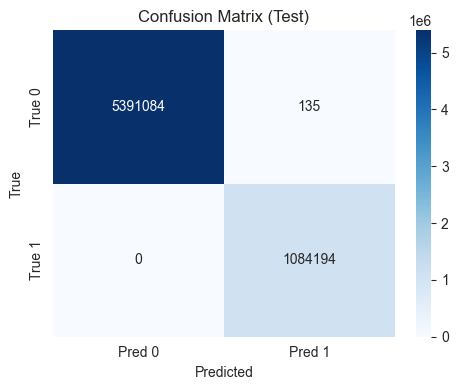

📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   5391219
           1     0.9999    1.0000    0.9999   1084194

    accuracy                         1.0000   6475413
   macro avg     0.9999    1.0000    1.0000   6475413
weighted avg     1.0000    1.0000    1.0000   6475413



In [22]:
cm, report = confusion_and_plot_temporal(model, test_snaps, device=device)
